***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* 2. [Mathematical Background](2_0_introduction.ipynb)
    * Previous: [2.13 Spherical Trigonometry](2_13_sampling_theory.ipynb)
    * Next: [2.x Further Reading and References](2_x_further_reading_and_references.ipynb)

***

Import standard modules:

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
import scipy.signal as scg
%matplotlib inline
from ipywidgets import interact

## 2.14 Mathematics of the CLEAN algorithm

Here we give the mathematical details behind the implementation of the CLEAN algorithm. In particular we present deconvolution as an iterative $\chi^2$ minimisation of a linear system of equations. You should review the notation for linear systems given in [$\S$ 2.10.3 &#10142;](2_10_linear_algebra.ipynb). Although, by this stage, you should have the necessary mathematics to understand this section, it is meant to supplement the material given in [$\S$ 6 &#10142;](../6_Deconvolution) and is best read after you have become familiar with the basic concepts behind imaging and deconvolution. 

### 2.14.1 Imaging as an iterative $\chi^2$ minimisation problem

The imaging problem can be formulated as a linear system of the form
$$ S F I = V_{obs} + \epsilon, \quad \mbox{where} \quad \epsilon \sim \mathcal{N}(0,\Sigma).$$
Here $S$ is the sampling operator, $F$ the Direct Fourier transform and $I$ is the image we are after. The assumption that $\epsilon$ is Gaussian noise allows us to form the $\chi^2$ distribution as

$$ \chi^2 = (S F I - V_{obs})^H W (S F I - V_{obs}), $$

where $W$ are the imaging weights. As already mentioned in $\S$ 2.10.3 (and elsewhere I am sure???), in interferometry, $W$ is not necessarily just the inverse of the covariance matrix $\Sigma^{-1}$. As will be demonstrated below the weights can actually be chosen to enhance certain desirable features in the image. For example, we could choose to implement uniform weighting which would down weight short baselines resulting in a sharper point spread function (denoted $I^{PSF}$) with smaller sidelobes. The downside of such a weighting scheme is that we lose signal to noise in the reconstructed dirty image (denoted $I^{D}$). We will give some examples below. For now our goal is to figure out how to find the image $I$ which minimises the $\chi^2$. Recall that this can be achieved by solving the normal equations. With the model as given above the gradient (also the Jacobian) is given by

$$ \partial_x \chi^2 = \mathbb{J}(I) = F^H S^H W (S F I - V_{obs}). $$

Similarly the Hessian follows on taking the second derivative

$$ \partial^2_x \chi^2 = \mathbb{H} = F^H S^H W S F. $$

The normal equations result from setting the gradient of the $\chi^2$ to zero i.e.

$$ F^H S^H W S F I = F^H S^H W V_{obs}. $$

Notice how the LHS is just the Hessian operating on $I$. The RHS, on the other hand, is just $I^{D}$ so that we can write the equation more succintly as

$$ \mathbb{H} I = I^{D}.  $$

Here $\mathbb{H}$ is a circulant matrix with each successive row being a right shifted version of $I^{PSF}$. Recalling (from $\S$ 2.10.4) that multiplication with a circulant matrix actually performs a discrete convolution, we clearly see that $I^D$ is the true sky convolved with the PSF of the instrument i.e. $I^{D} = I^{PSF} * I$. In principle the solution to the normal equations is given by

$$ I = \mathbb{H}^{-1} I^D, $$

showing why we can think of the solution to the normal equations as a deconvolution. Unfortunately, for a sparsely sampled array, the sampling matrix $S$ will not have full column rank and therefore can't be inverted. This forces the use of approximate methods to solve the normal equations. The CLEAN algorithm does this by using an iterative procedure similar to Newton's method i.e. with an update rule of the form

$$ I_{i+1} = I_i + g \tilde{H}^{-1} J(I_i), $$

where $\tilde{H}$ is an invertible approximation to the Hessian matrix and the loop gain $g$ controls the step size. 

In imaging the iterative solution is usually implemented using major and minor cycles. To see how this works first note that, for a given model image $I^{M}$, the Jacobian is just the residual image i.e. 

$$ J(I^{M}) = F^H S^H W (S F I^M - V_{obs}) = I^{R}. $$

Thus one iteration of the optimisation method would be given by 

$$ I^M_{i+1} = I^M_{i} + g \tilde{H}^{-1} I^R_{i}, $$

where $\tilde{H}$ is constructed by invoking a number of a priori assumptions. Recall that an ideal interferometer (i.e. one with complete $uv$-coverage) will have a delta function as its PSF. This suggests that we can, in principle, eliminate the corrupting effects of the instrument by assuming that the PSF is a delta function. This is equivalent to a diagonal approximation of the Hessian matrix. If we also assume that the PSF is spatially invariant all the elements on the diagonal will be the same and the Hessian reduces to a single number viz. the value of $I^{PSF}$ at the center. This value is also known as the sum of weights $w_{sum}$ and we will see where this name comes from below. With these two assumptions we can construct 

$$ \tilde{H} = w_{sum} = \mbox{peak}(I^{PSF}). $$

This allows us to construct what is known as the principal solution $\hat{I}^D$ as

$$ \hat{I}^D = \tilde{H}^{-1} I^D, \qquad \hat{I}^{PSF} = \tilde{H}^{-1} I^{PSF}. $$

Note that we are using a hat to denote normalisation by the peak of the PSF. The principal solution is basically just the dirty image normalised to have units which are comparable to the model image. To apply the update step we start by searching for the peak in $I^D$. This peak will contain flux from the pixel in the model image centered at the same location, as well as those contributed by the the sidelobes of sources at different locations. This is the reason why we have to use a loop gain of $g < 1$, otherwise we will be adding sidelobes of the other sources to our model image. Once we have performed the update step we can compute the new residual image (i.e. evaluate the Jacobian) and repeat until some prespecified convergence criterion has been reached. This is known as one major cycle during CLEAN deconvolutions. Since it involves switching from the image domain to visibilities and back again, it is quite expensive operation. As a result the algorithm is usually implemented differently and this is where the minor cycle comes in. Major cycles evaluate the Jacobian while minor cycles implement more efficient (but less accurate) updates to the model image. Basically the minor cycle does multiple updates of the model image to avoid switching between domains so frequently. This requires performing the subtraction (equivalently computing the Jacobian or updating the residual image $I^R$) in the image domain and can be implemented approximately by subtracting out the PSF centered at the location of the current brightest pixel from the entire image. Keep in mind that, since we are evaluating the PSF on a finite grid, this inevitably introduces discretisation errors which must be corrected for in the major cycle. Actually all of this is best illustrated with a simple example. 

### 2.14.2 CLEAN illustration in 1D

Our aim is to develop the CLEAN algorithm in one dimension. We start by implementing the basic Hogbom CLEAN algorithm (which implements the minor cycle) and then extend it to a full Cotton-Schwabb CLEAN (which evaluates the Jacobian in visibility space). 

Recall that an interferometer measures the Fourier transform of the sky brightness distribution. Assuming an unpolarised sky and an ideal interferometer this is captured by the Van Cittert-Zernike theorem i.e.

$$ V(u,v) = \int A(l,m) I(l,m)e^{-2 \pi i (ul + vm)}dldm, $$

where $A(l,m)$ is the primary beam pattern, $I(l,m)$ is the sky brightness ditribution and $V(u,v)$ the visibilities measured by the interferometer. To illustrate the main concepts behind deconvolution we will study the following simplified 1D model

$$ V(u) = \int I(l)e^{-2 \pi i ul} dl = \mathcal{F}(I), $$

where the $\mathcal{F}$ operator represents the Fourier transform.

We will start by constructing a sky model containing only delta functions (this would correspond to unresolved point sources). Suppose our interferometer has a maximum field of view of $l \in [-1,1]$ in which there are only two point sources located at $l_1 = -0.15$ and $l_2 = 0.25$ with a total intensity of $I_{s_1} = 1$Jy and $I_{s_2} = 2.5$Jy respectively. Such a sky model can be parametrised as

$$ I(l) = I_{s_1} \delta(l - l_1) + I_{s_2} \delta(l - l_2).  $$

The visibilities corresponding to this sky model are easy to compute analytically. They are

$$ V(u) = I_{s_1} e^{-2 \pi i u l_1} + I_{s_2} e^{-2 \pi i u l_2}.  $$

This can be visualised as follows.

(-5.0, 5.0)

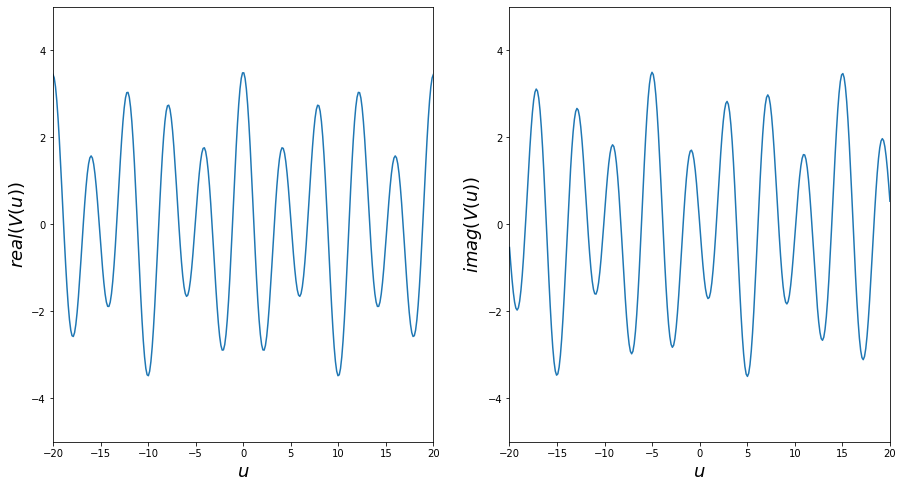

In [2]:
N = 300 # the maximum number of "baselines" that can be sampled
u = np.linspace(-20,20,N) # a grid of "baselines"

Npix = 300 # the number of "pixels" in the image
lmin = -0.5 
lmax = 0.5
l = np.linspace(lmin,lmax,Npix) # The region where we want to reconstruct the image

#deltal = l[1]-l[0]

Is1 = 1 # true flux of source one
Is2 = 2.5 # true flux of second source

# Set locations of sources (also ensuring they are at pixel centres)
l1 = l[np.argwhere(l < -0.15)[-1]]
l2 = l[np.argwhere(l < 0.25)[-1]]

# Compute the anaytic form of the visibilities
V = Is1*np.exp(-2*np.pi*1.0j*u*l1) + Is2*np.exp(-2*np.pi*1.0j*u*l2)

# Plot the visibilities
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))

ax[0].plot(u,np.real(V))
ax[0].set_xlabel('$u$',fontsize=18)
ax[0].set_ylabel('$real(V(u))$',fontsize=18)
ax[0].set_xlim(-20.,20.)
ax[0].set_ylim(-5,5)

ax[1].plot(u,np.imag(V))
ax[1].set_xlabel('$u$',fontsize=18)
ax[1].set_ylabel('$imag(V(u))$',fontsize=18)
ax[1].set_xlim(-20.,20.)
ax[1].set_ylim(-5,5)

This is the theoretical signal corresponding to our sky model (over the finite domain over which we can make measurements). Unfortunately an interferometer only measures this signal at a finite number of locations in the $uv$-plane. This can be expressed mathematically by including a sampling function $S(u)$ in our measurement equation as follows

$$ V^{obs}(u) = S(u) \int I(l)e^{-2 \pi i ul} dl = S \mathcal{F} I, $$

where $S(u) = 1$ at locations where we have measurements and $S(u) = 0$ otherwise. This results in a discretised linear model in the same form as we have above. We are going to start by considering the noiuse free case in which all observations are equally weighted (i.e. so called naturally weighted) and give a demonstration of the effect that the weighting function has right at the end. Inverting this equation gives what is known as the dirty image $I^D$

$$I^D = \mathcal{F}^{-1} S \mathcal{F} I = I^{PSF} * I, \quad \mbox{where} \quad I^{PSF} = \mathcal{F}^{-1} S, $$

and we have employed the convolution theorem in the last step. From this it should be clear that the image $I^D$ reconstructed by naively applying the inverse Fourier transform to the observed visibilities $V^{obs}$ is the convolution of the true image with the point spread function (PSF) of the instrument viz. $I^{PSF}$. For this reason $I^D$ is referred to as the dirty image. Deconvolution is the process by which we attempt to remove the corrupting affects of the instrument in order to reconstruct the true image of the sky. Before we can illustrate the deconvolution process we will need to simulate this affect on our model. The code snippet below does exactly that. 

In [3]:
# Get indices at which we measure V
Nsample = 201
Sindices = np.sort(np.unique(np.random.randint(0, N, Nsample))) # unique used to ensure we dont sample any given point more than once 
Nsample = Sindices.size # true number of sampels

# Create sampling function
S = np.zeros(N)
S[Sindices] = 1.0

# This is to compare DFT with FFT
S2 = np.ones(Nsample)
Vobs2 = V[Sindices]


# Get the observed visibilities
Vobs = np.zeros(N)
Vobs[Sindices] = V[Sindices]

# Construct FT kernel
F = np.exp(-2.0*np.pi*1.0j*np.outer(u,l))

F2 = np.exp(-2.0*np.pi*1.0j*np.outer(u[Sindices],l)) # for comparison with FFT
lpsf = np.linspace(2*lmin,2*lmax,2*N+1)
F2psf = np.exp(-2.0*np.pi*1.0j*np.outer(u[Sindices],lpsf))

# Do the iFT on S (recal FT is Hermitian FF^H = I => F^H = F^{-1})
Ipsf = np.real(np.dot(F.conj().T,S))

Ipsf2 = np.real(np.dot(F2psf.conj().T,S2)) # for comparison with FFT

# Get the dirty image
ID = np.real(np.dot(F.conj().T,Vobs))
ID2 = np.real(np.dot(F2.conj().T,Vobs2)) # for comparison with FFT


Notice that we have computed two versions of both $I^D$ and $I^{PSF}$ in the above code snippet. This is simply to illustrate the effects of aliasing when using a regular grid (as necessitated by use of the FFT algorithm). Lets first have a look at the what we would get if we sampled the visibilities on a regular grid. 

(-0.5, 0.5)

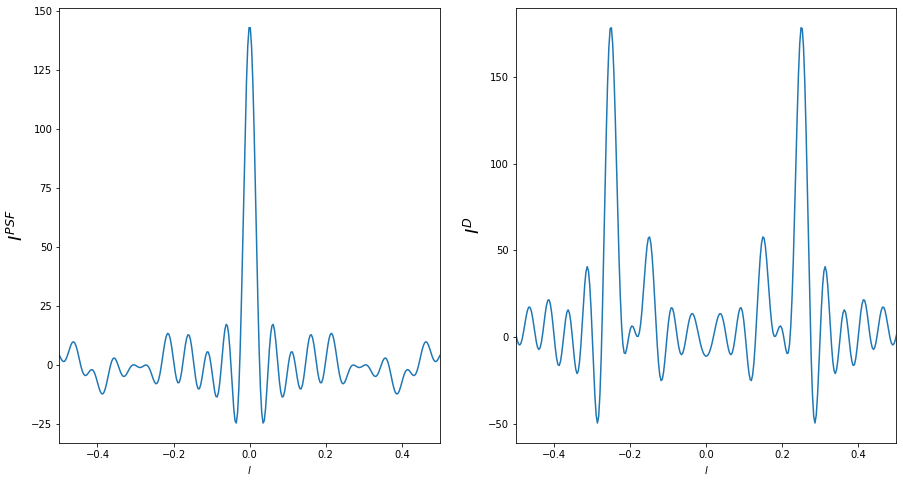

In [4]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))

ax[0].plot(l,Ipsf)
ax[0].set_xlabel('$l$')
ax[0].set_ylabel('$I^{PSF}$',fontsize=18)
ax[0].set_xlim(lmin,lmax)
#ax[0].set_ylim(-5,5)

ax[1].plot(l,ID)
ax[1].set_xlabel('$l$')
ax[1].set_ylabel('$I^D$',fontsize=18)
ax[1].set_xlim(lmin,lmax)
#ax[1].set_ylim(-5,5)

The figure on the left shows the PSF that results from imperfect sampling in the "$uv$-plane". We should expect to see something that resembles a sinc function (why?). On the right is the dirty "image" we would see if we did not account for aliasing. Use of the FFT inevitably requires the use of an anti-aliasing filter too. In this tut we get around that by using the irregularly sampled version of $V^{obs}$ (similar to using the dirct Fourier transform in imaging). The figures below show the anti-aliased version of $I^D$. Note that we have also computed $I^{PSF}$ out to double the distance as compared to $I^D$. This will be reuired for the deconvolution.       

(-0.5, 0.5)

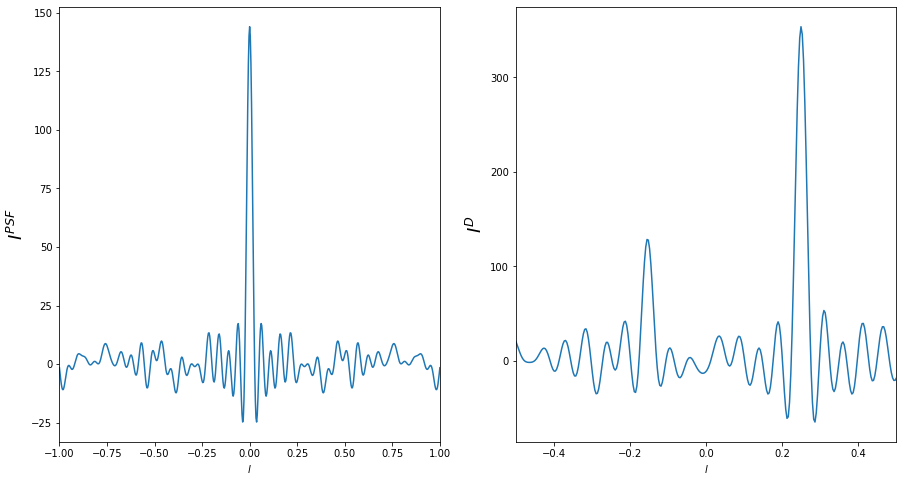

In [5]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))

ax[0].plot(lpsf,Ipsf2)
ax[0].set_xlabel('$l$')
ax[0].set_ylabel('$I^{PSF}$',fontsize=18)
ax[0].set_xlim(2*lmin,2*lmax)
#ax[0].set_ylim(-5,5)

ax[1].plot(l,ID2)
ax[1].set_xlabel('$l$')
ax[1].set_ylabel('$I^D$',fontsize=18)
ax[1].set_xlim(lmin,lmax)
#ax[1].set_ylim(-5,5)

Now there are clearly two main peaks visible in $I^{D}$ but the units seem all wrong. Normalising both by the max of the PSF we see something that is closer to the original input model. 

(-0.5, 0.5)

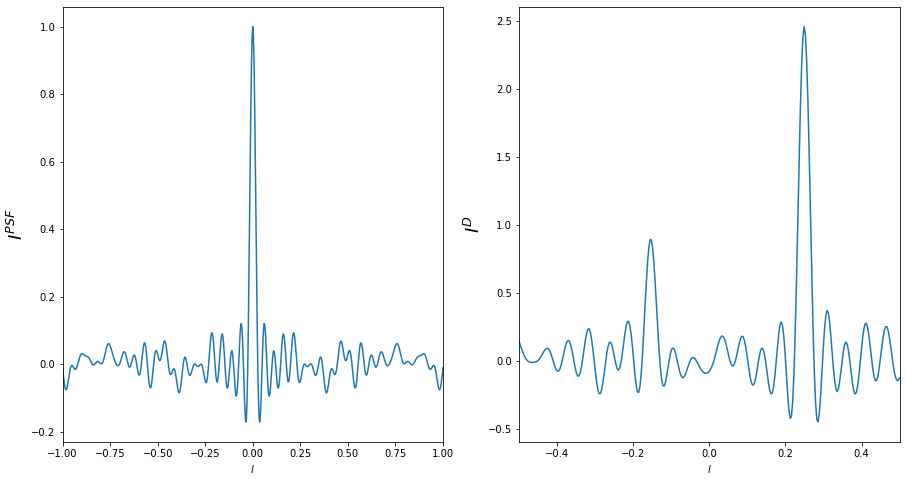

In [6]:
maxPSF = Ipsf2.max()

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))

ax[0].plot(lpsf,Ipsf2/maxPSF)
ax[0].set_xlabel('$l$')
ax[0].set_ylabel('$I^{PSF}$',fontsize=18)
ax[0].set_xlim(2*lmin,2*lmax)


ax[1].plot(l,ID2/maxPSF)
ax[1].set_xlabel('$l$')
ax[1].set_ylabel('$I^D$',fontsize=18)
ax[1].set_xlim(lmin,lmax)

 We are now ready to implement the Hogbom CLEAN. The function below implements the Hogbom CLEAN algorithm in 1D. 

In [7]:
def Hogbom_CLEAN(IR,Ipsf,gamma=0.1,tol=0.1,maxiter=200,restore=False):
    # Initialise
    i = 1
    Npix = IR.size
    Npsfmax = np.argwhere(Ipsf==1.0)
    IM = np.zeros([Npix])
    # Find the first peak
    p = np.argwhere(abs(IR) == abs(IR).max()).squeeze()
    Ipeak = IR[p]
    while abs(Ipeak) > tol and i <= maxiter:
        # Update the residual
        IR -= gamma*Ipeak*Ipsf[int(Npsfmax - p):int(Npsfmax + Npix - p)]
        # Update the sky model
        IM[p] += gamma*Ipeak
        # Find next peak
        p = np.argwhere(abs(IR) == abs(IR).max()).squeeze()
        Ipeak = IR[p]
        i += 1
        #print i, Ipeak, p
    if i >= maxiter:
        print("Warning maximum number of iterations exceeded")
    return IM, IR

Ok so lets try it out

(-0.5, 0.5)

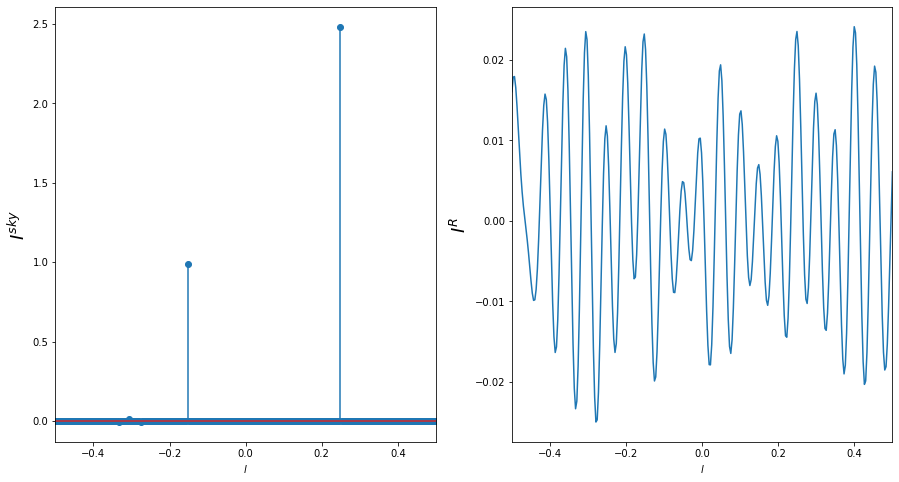

In [8]:
Ipsf = Ipsf2/maxPSF
ID = ID2/maxPSF
IM, IR = Hogbom_CLEAN(ID.copy(),Ipsf.copy(),tol=0.025)

# Plot the results
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))

ax[0].stem(l,IM)
ax[0].set_xlabel('$l$')
ax[0].set_ylabel('$I^{sky}$',fontsize=18)
ax[0].set_xlim(lmin,lmax)


ax[1].plot(l,IR)
ax[1].set_xlabel('$l$')
ax[1].set_ylabel('$I^R$',fontsize=18)
ax[1].set_xlim(lmin,lmax)

The output above is typical of Hogbom CLEAN. ALthough it has found the peaks in approximately the right locations, sometimes the flux gets spread out over neighbouring pixels. If we were to sum the fluxes from these pixels they would add up very nearly to the input flux. This is a limitation of working exclusively in image space where discretisation errors are inevitable. The Cotton-Schwab CLEAN algorithm overcomes this by performing the subtraction in visbility space. Unfortunately switching between image and visibility space is usually the most expensive part of the algorithm. It is therefore impractical to switch between image and visibility space each time the model gets updated. Sufficient accuracy can usually be obtained by only cleaning down to 0.1 or 0.2 of the peak in the residual image during each major cycle. 

In [9]:
def CS_CLEAN(Vobs, F, Ipsf, peak_Factor=0.2, maxmajoriter=10,majortol = 0.01):
    # Get max of the PSF and normalise
    maxPSF = Ipsf.max()
    Ipsf /= maxPSF 
    
    # get the dirty image and normalise
    ID = np.real(np.dot(F.conj().T,Vobs))/maxPSF
    
    # Initialise the model
    IMmajor = np.zeros_like(ID)
    
    i = 0
    IR = ID.copy()
    
    # Find the first peak
    p = np.argwhere(abs(IR) == abs(IR).max()).squeeze()
    Ipeak = IR[p]
    while abs(Ipeak) > majortol and i <= maxmajoriter:        
        # Do Hogbom step
        IM, IR = Hogbom_CLEAN(IR,Ipsf,tol=peak_Factor*Ipeak)
        
        IMmajor += IM
        
        # Evaluate the Jacobian
        Vpred = np.dot(F,IMmajor)
        Vres = Vobs - Vpred
        
        # Get new residuals and normalise by max of PSF
        IR = np.real(np.dot(F.conj().T,Vres))/maxPSF
        
        # Find the peak
        p = np.argwhere(abs(IR) == abs(IR).max()).squeeze()
        Ipeak = IR[p]  
        i += 1
        
    
    return IMmajor, IR
    

(-0.5, 0.5)

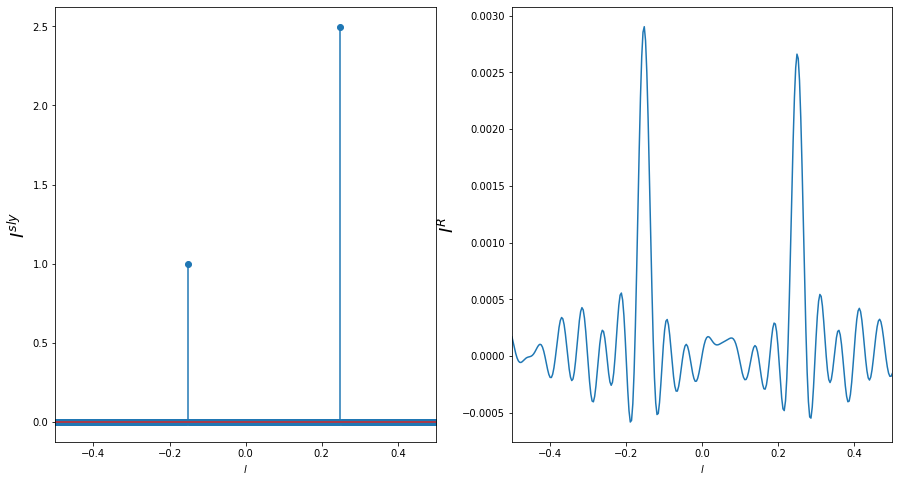

In [10]:
IM, IR = CS_CLEAN(Vobs2, F2, Ipsf2.copy())

# Plot the results
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))

ax[0].stem(l,IM)
ax[0].set_xlabel('$l$')
ax[0].set_ylabel('$I^{sly}$',fontsize=18)
ax[0].set_xlim(lmin,lmax)

ax[1].plot(l,IR)
ax[1].set_xlabel('$l$')
ax[1].set_ylabel('$I^R$',fontsize=18)
ax[1].set_xlim(lmin,lmax)

Clearly the CS CLEAN does a lot better at recovering the true fluxes of the sources. We have only one job left to do and that is to create the restored image. The restored image is the model image convolved with an ideal beam (i.e. one with no sidelobes). The ideal beam can be constructed by fitting a Gaussian to the primary lobe of the PSF.    

In [11]:
def Gaussian_1D(x, sigma, l):
    return sigma**2*np.exp(-x**2/(2*l**2))

def fit_Gaussian_1D(Ipsf,lpsf):
    I = np.argwhere(Ipsf > 0.5*Ipsf).squeeze()
    data = Ipsf[I]
    x = (lpsf[I])
    
    initial_guess = (1.0,0.5)
    
    popt, pcov = opt.curve_fit(Gaussian_1D, x, data, p0=initial_guess)
    Ipsf_ideal = Gaussian_1D((lpsf), *popt)
    Ipsf_ideal/=Ipsf_ideal.max()
    
    return Ipsf_ideal
    

(0.0, 3.5)

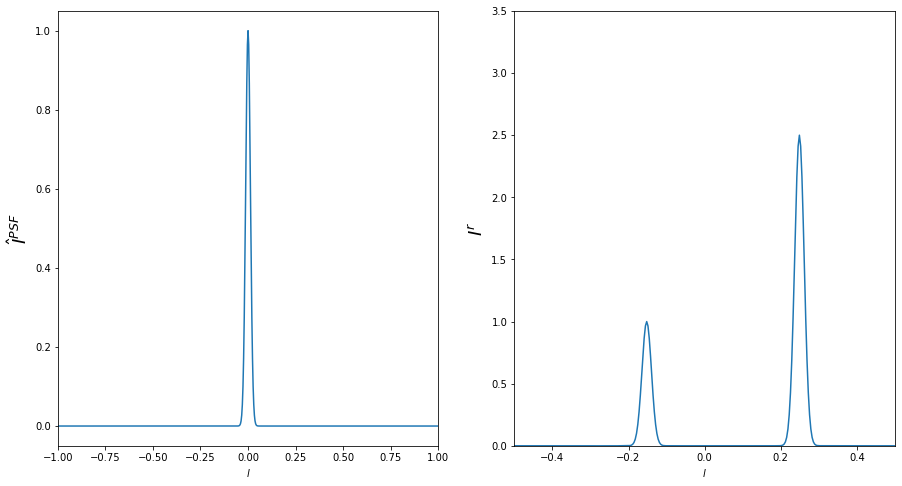

In [12]:
Ipsf_ideal = fit_Gaussian_1D(Ipsf,lpsf)

# Convolve with sky model
Irestored = scg.convolve(IM,Ipsf_ideal, mode='same')

# Add back the residuals
Irestored += IR

# Plot the results
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))

ax[0].plot(lpsf,Ipsf_ideal)
ax[0].set_xlabel('$l$')
ax[0].set_ylabel('$\hat{I}^{PSF}$',fontsize=18)
ax[0].set_xlim(-1,1)

ax[1].plot(l,Irestored)
ax[1].set_xlabel('$l$')
ax[1].set_ylabel('$I^r$',fontsize=18)
ax[1].set_xlim(lmin,lmax)
ax[1].set_ylim(0,3.5)

### 2.14.3 Weighting and the PSF

This is incomplete. I thought it might be cool to demonstrate the effect of weighting for the 1D problem. Slider controls the degree of weighting.

In [13]:
def inter_PSF(S,F,u,R,l):
    Ws = np.zeros(u.size)
    I = np.argwhere(u<0)
    Ws[I] = np.abs((-u[I])**R)
    I = np.argwhere(u>=0)
    Ws[I] = np.abs(u[I]**R)
    Ipsf = np.real(np.dot(F.conj().T,S*Ws))
    Ipsf /= Ipsf.max()
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
    ax[0].plot(l,Ipsf)
    ax[0].set_xlim(-1,1)
    ax[0].set_ylim(-0.1,1.1)
    ax[0].set_title(r'$PSF$')
    ax[1].plot(u,Ws)
    ax[1].set_xlim(-20,20)
    ax[1].set_ylim(0,80)
    ax[0].set_title(r'$Visibility Weights$')

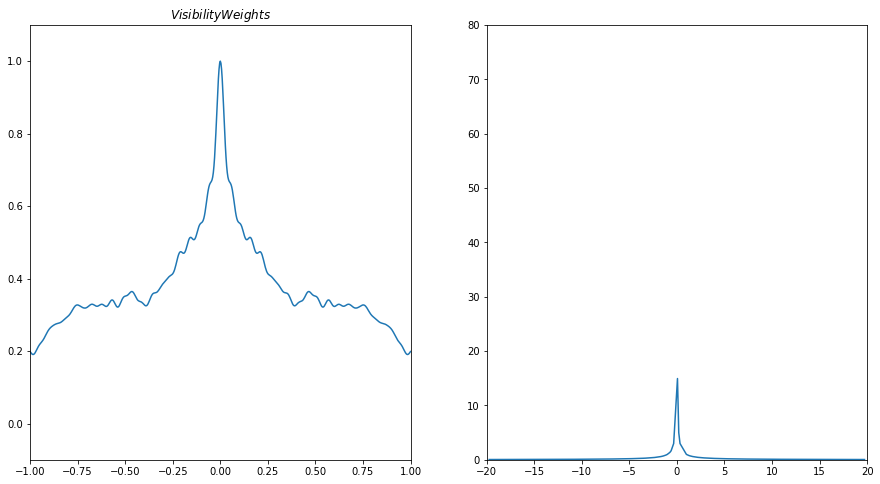

In [14]:
interact(lambda R:inter_PSF(S=S2,F=F2psf,u=u[Sindices],R=R,l=lpsf),
                R=(-1.5,1.5,0.25)) and None

***

Next: [2.x Further Reading and References](2_x_further_reading_and_references.ipynb)